In [68]:
#### Preamble ####
# Purpose: Model the data to predict BTC/USDT's moving direction
# Author: Jiazhou(Justin) Bi
# Date: 16 Nov 2024
# Contact: justin.bi@mail.utoronto.ca
# License: None
# Pre-requisites: see requirements.txt
# Any other information needed? None

# Loading the Test Data

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical, plot_model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, LSTM
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
df_1m = pd.read_parquet('../data/03-lagged_differences_data/lagged_differences_data_1m.parquet')
df_1h = pd.read_parquet('../data/03-lagged_differences_data/lagged_differences_data_1h.parquet')
df_1d = pd.read_parquet('../data/03-lagged_differences_data/lagged_differences_data_1d.parquet')
df_1m.head()
#data\03-lagged_differences_data\lagged_differences_data_1d.parquet

,index,open,high,low,close,volume,was_missing,direction,open_diff,high_diff,low_diff,close_diff
0,2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,0,1,19.08,19.08,19.08,19.08
1,2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,0,-1,-19.08,-19.08,-19.08,-19.08
2,2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,0,0,0.00,0.00,0.00,0.00
3,2017-08-17 04:05:00,4261.48,4261.48,4261.48,4261.48,0.000000,0,0,0.00,0.00,0.00,0.00
4,2017-08-17 04:06:00,4261.48,4261.48,4261.48,4261.48,0.000000,0,0,0.00,0.00,0.00,0.00


# RNN

## RNN for direction prediction

### 1-minute interval direction prediction

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


c:\Users\melty\anaconda3\envs\ml\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 116s 1ms/step - accuracy: 0.0245 - loss: 0.9761 - val_accuracy: 0.0446 - val_loss: 0.9555
Epoch 2/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 116s 1ms/step - accuracy: 0.0241 - loss: 0.9761 - val_accuracy: 0.0446 - val_loss: 0.9556
Epoch 3/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 117s 1ms/step - accuracy: 0.0242 - loss: 0.9759 - val_accuracy: 0.0446 - val_loss: 0.9556
Epoch 4/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 114s 1ms/step - accuracy: 0.0237 - loss: 0.9763 - val_accuracy: 0.0446 - val_loss: 0.9554
Epoch 5/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 112s 1ms/step - accuracy: 0.0238 - loss: 0.9763 - val_accuracy: 0.0446 - val_loss: 0.9558
Epoch 6/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 113s 1ms/step - accuracy: 0.0236 - loss: 0.9765 - val_accuracy: 0.0446 - val_loss: 0.9554
Epoch 7/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 113s 1ms/step - accuracy: 0.0238 - loss: 0.9763 - val_accuracy: 0.0446 - val_loss: 0.9554
Epoch 8/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 113s 1ms/step - ac

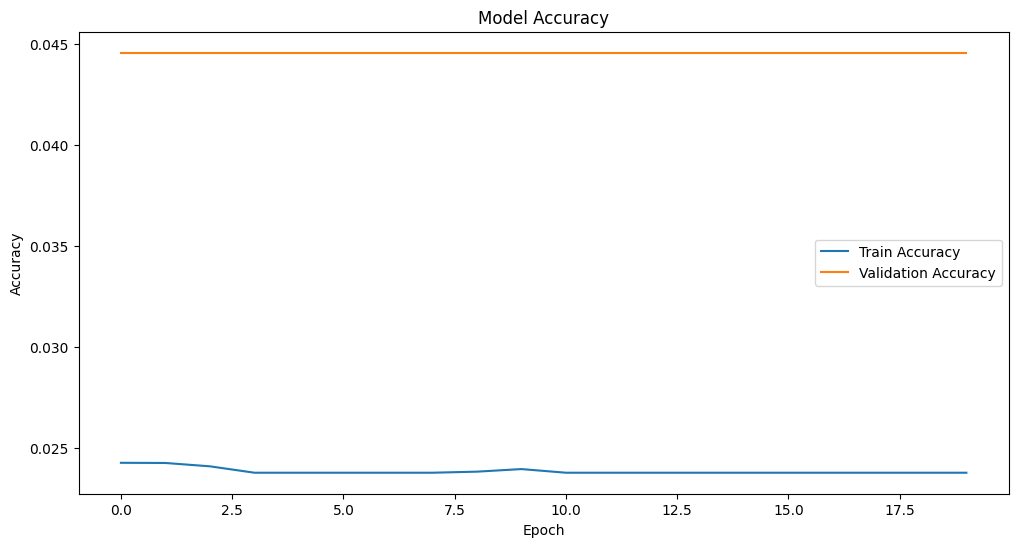

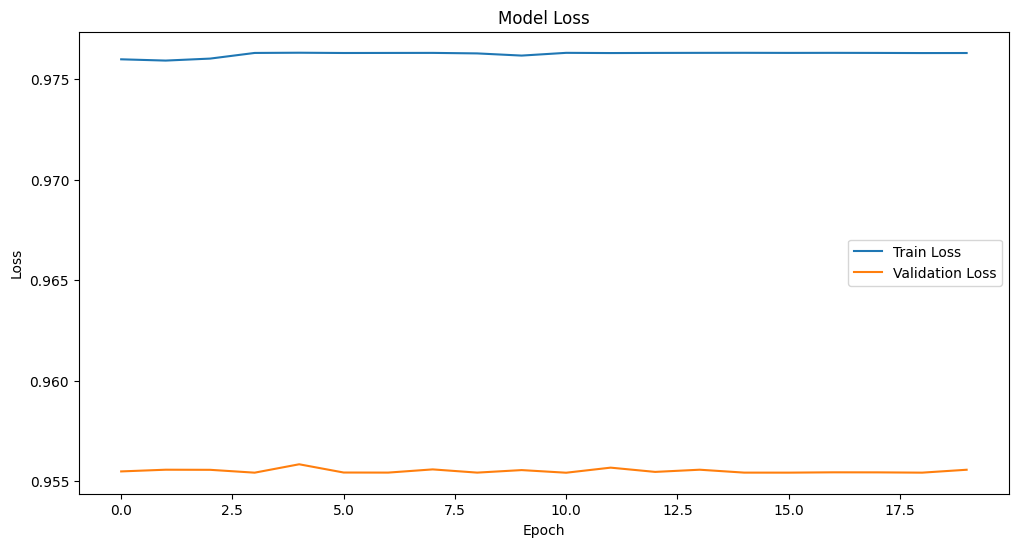

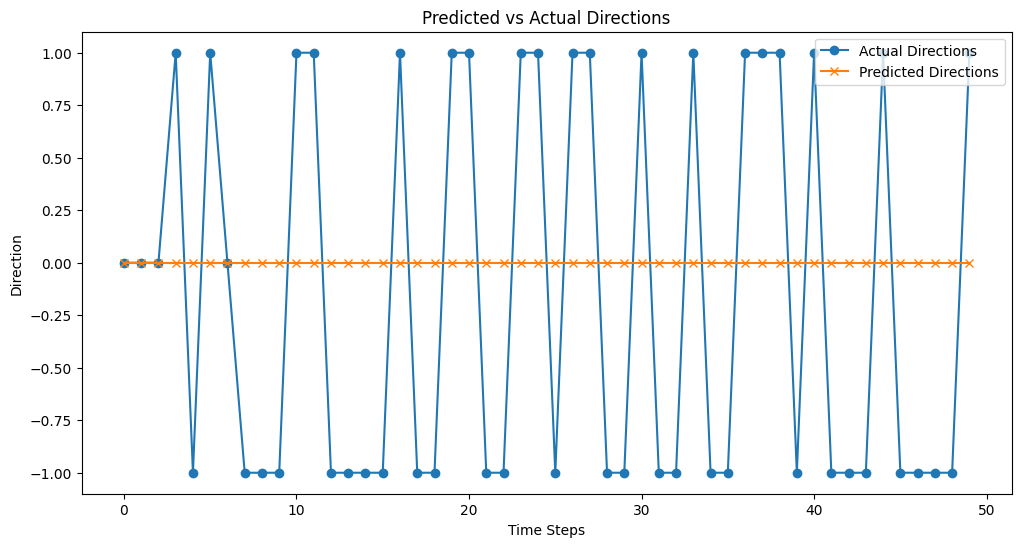

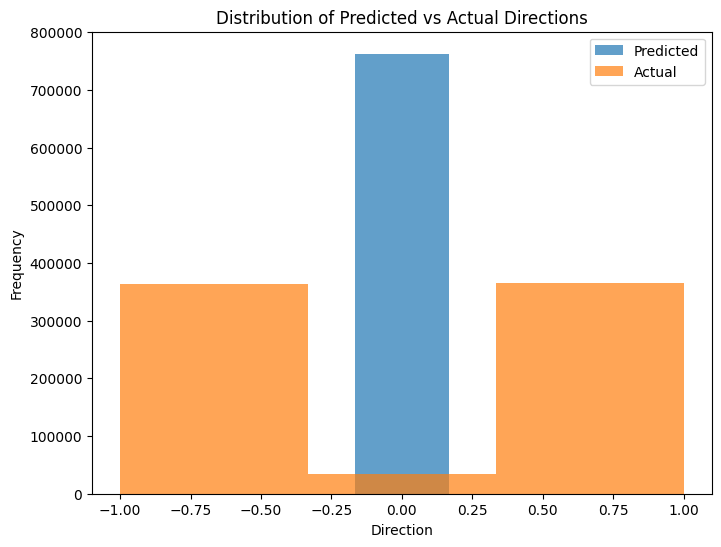

In [ ]:
# Define features and target
features = ['open_diff', 'high_diff', 'low_diff', 'close_diff', 'volume', 'was_missing']
target = 'direction'
X = df_1m[features]
y = df_1m[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Function to create sequences
def create_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

# Create sequences
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y.values, time_steps=time_steps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Define the RNN model
model = Sequential([
    SimpleRNN(64, activation='relu', input_shape=(time_steps, X_seq.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='tanh')  # Output for direction (-1, 0, 1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Visualize the model architecture
plot_model(model, to_file='rnn_model_architecture.png', show_shapes=True, show_layer_names=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predict the directions
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred).flatten()  # Round to nearest class (-1, 0, 1)

# Visualize Training Progress
# Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize Predictions vs Actuals
plt.figure(figsize=(12, 6))
plt.plot(y_test[:50], label='Actual Directions', marker='o')
plt.plot(y_pred_classes[:50], label='Predicted Directions', marker='x')
plt.title('Predicted vs Actual Directions')
plt.xlabel('Time Steps')
plt.ylabel('Direction')
plt.legend()
plt.show()

# Visualize Prediction Distribution
plt.figure(figsize=(8, 6))
plt.hist(y_pred_classes, bins=3, alpha=0.7, label='Predicted')
plt.hist(y_test, bins=3, alpha=0.7, label='Actual')
plt.title('Distribution of Predicted vs Actual Directions')
plt.xlabel('Direction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Save the model
#model.save('../model/RNN/Directional_Classification_Model/rnn_direction_model_1m.h5')
model.save('../model/RNN/Directional_Classification_Model/rnn_direction_model_1m.keras')

### 1-hour interval direction prediction

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
Epoch 1/20


c:\Users\melty\anaconda3\envs\ml\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1589/1589 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4965 - loss: 0.7988 - val_accuracy: 0.5120 - val_loss: 0.6953
Epoch 2/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5060 - loss: 0.7042 - val_accuracy: 0.5120 - val_loss: 0.6945
Epoch 3/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5032 - loss: 0.7012 - val_accuracy: 0.5120 - val_loss: 0.6938
Epoch 4/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5094 - loss: 0.6990 - val_accuracy: 0.4880 - val_loss: 0.6941
Epoch 5/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5053 - loss: 0.6998 - val_accuracy: 0.5120 - val_loss: 0.6946
Epoch 6/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5037 - loss: 0.6987 - val_accuracy: 0.5120 - val_loss: 0.6938
Epoch 7/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5058 - loss: 0.6982 - val_accuracy: 0.5120 - val_loss: 0.6943
Epoch 8/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5023 - loss: 0.6988 - val_accurac

c:\Users\melty\anaconda3\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\melty\anaconda3\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\melty\anaconda3\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


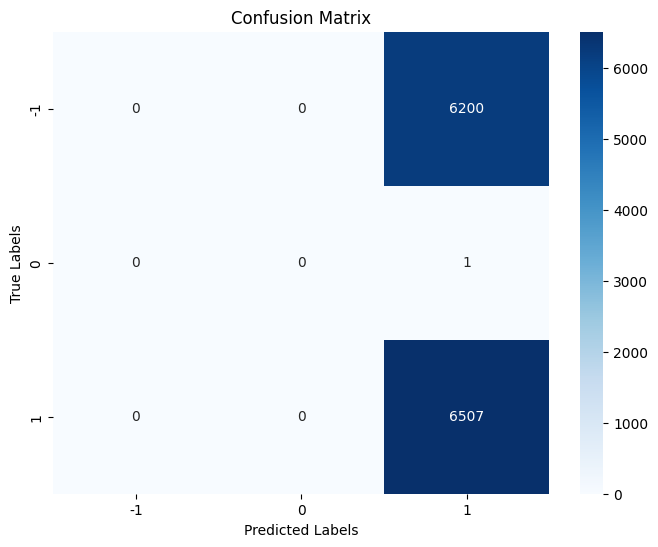

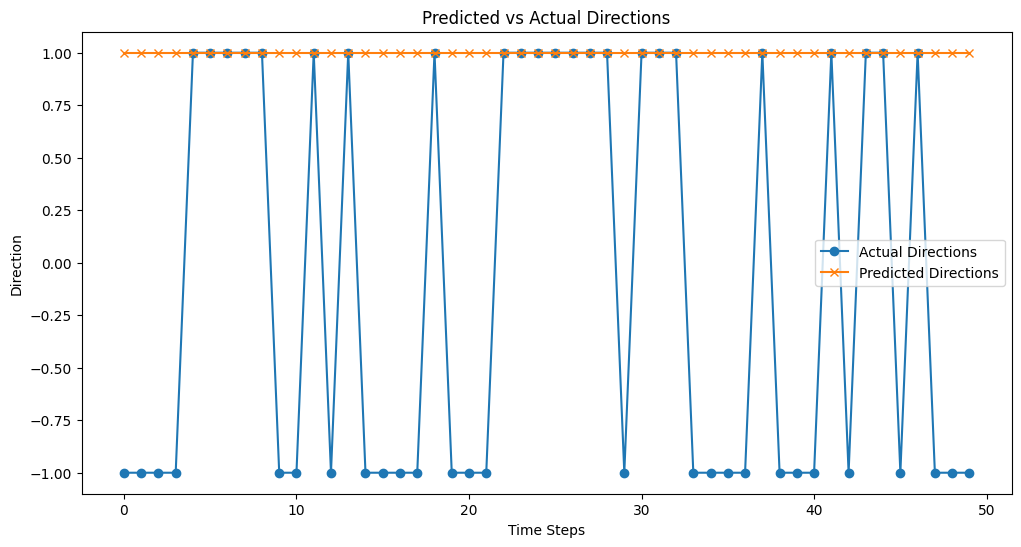

In [10]:
# Define features and target
features = ['open_diff', 'high_diff', 'low_diff', 'close_diff', 'volume', 'was_missing']
target = 'direction'
X = df_1h[features]
y = df_1h[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Function to create sequences
def create_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

# Create sequences
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y.values, time_steps=time_steps)

# One-hot encode labels
y_seq_categorical = to_categorical(y_seq + 1)  # Shift labels (-1, 0, 1) to (0, 1, 2) for one-hot encoding

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq_categorical, test_size=0.2, shuffle=False)

# Define the RNN model
model = Sequential([
    SimpleRNN(128, activation='relu', input_shape=(time_steps, X_seq.shape[2])),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 classes (-1, 0, 1)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Visualize the model architecture
plot_model(model, to_file='rnn_model_architecture_multiclass.png', show_shapes=True, show_layer_names=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predict the directions
y_pred_prob = model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred_prob, axis=1) - 1  # Shift back to original labels (-1, 0, 1)
y_test_classes = np.argmax(y_test, axis=1) - 1  # Shift back to original labels (-1, 0, 1)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=["-1", "0", "1"]))

# Generate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Display the confusion matrix numerically
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["-1", "0", "1"], yticklabels=["-1", "0", "1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Visualize Predictions vs Actuals
plt.figure(figsize=(12, 6))
plt.plot(y_test_classes[:50], label='Actual Directions', marker='o')
plt.plot(y_pred_classes[:50], label='Predicted Directions', marker='x')
plt.title('Predicted vs Actual Directions')
plt.xlabel('Time Steps')
plt.ylabel('Direction')
plt.legend()
plt.show()

# Save the model
model.save('../model/RNN/Directional_Classification_Model/rnn_direction_model_multiclass.keras')


### 1-day interval direction prediction

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
Epoch 1/20


c:\Users\melty\anaconda3\envs\ml\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5014 - loss: 0.7004 - val_accuracy: 0.5208 - val_loss: 0.6926
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5010 - loss: 0.6962 - val_accuracy: 0.5152 - val_loss: 0.6926
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4708 - loss: 0.6980 - val_accuracy: 0.5227 - val_loss: 0.6929
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5177 - loss: 0.6926 - val_accuracy: 0.5189 - val_loss: 0.6930
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5244 - loss: 0.6917 - val_accuracy: 0.5114 - val_loss: 0.6929
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5107 - loss: 0.6942 - val_accuracy: 0.5170 - val_loss: 0.6932
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5144 - loss: 0.6932 - val_accuracy: 0.5246 - val_loss: 0.6931
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4873 - loss: 0.6943 - val_accuracy: 0.5284 - val_loss: 0.6929
Epo

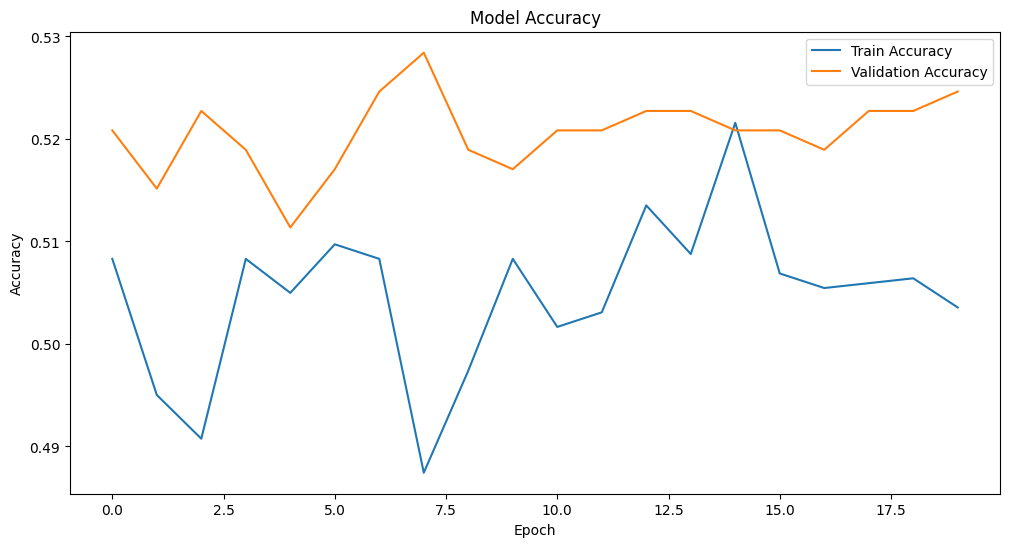

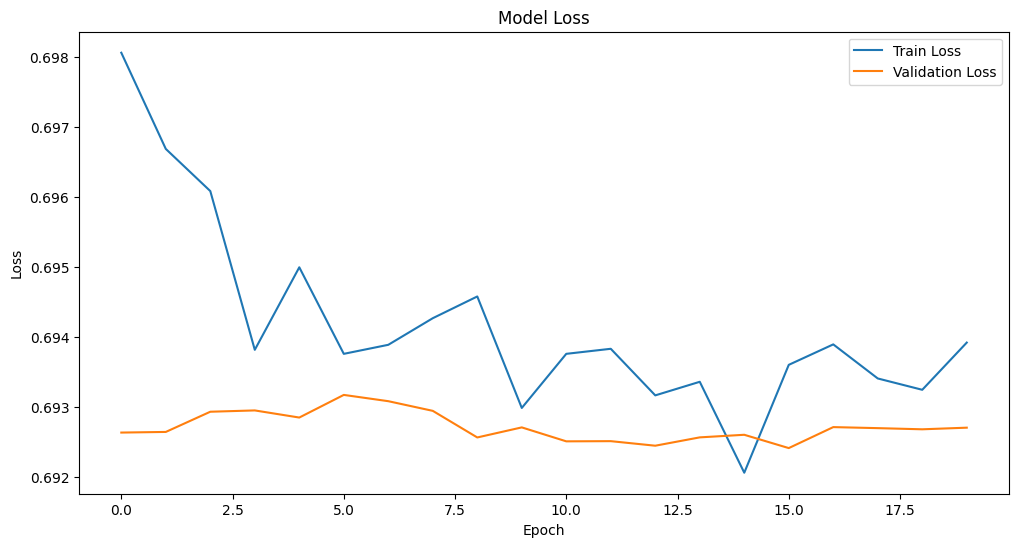

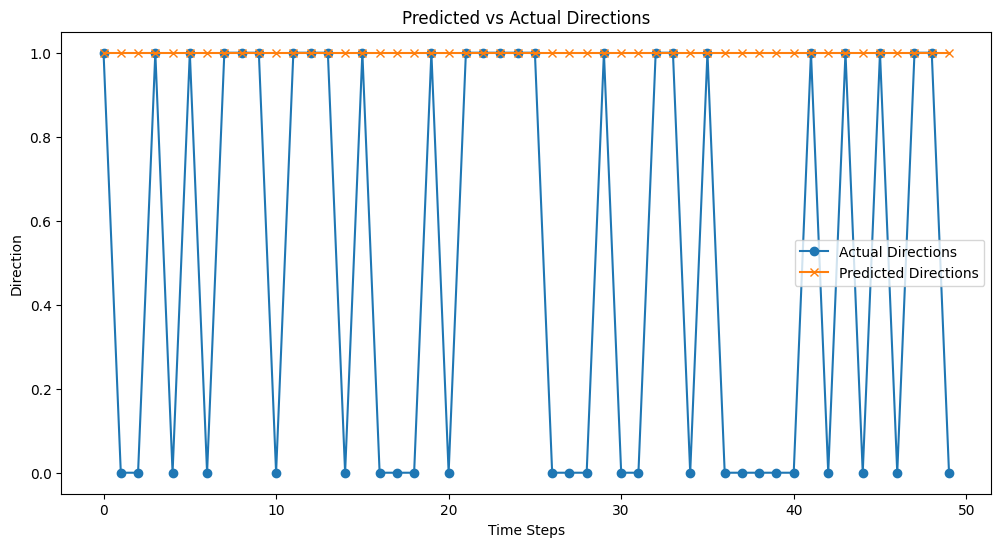

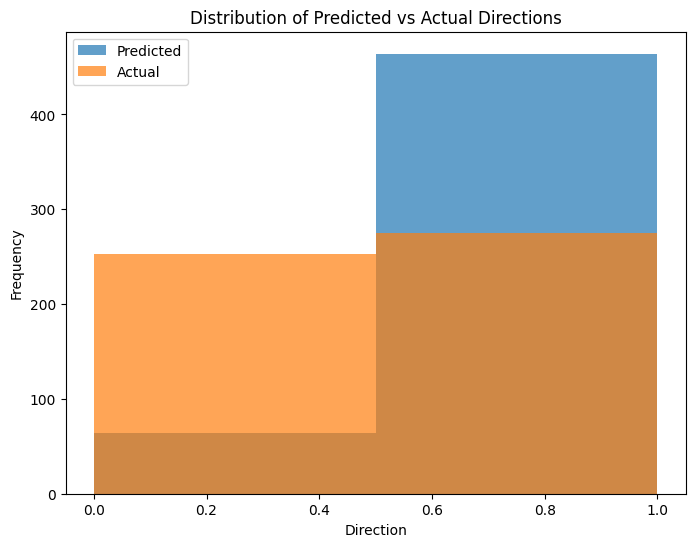

In [72]:
# Define features and target
features = ['open_diff', 'high_diff', 'low_diff', 'close_diff', 'volume']
target = 'direction'
X = df_1d[features]
y = df_1d[target]

# Map -1 to 0 for binary classification
y_binary = (y + 1) // 2  # Map -1 to 0 and keep 1 as is

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Function to create sequences
def create_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

# Create sequences
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y_binary.values, time_steps=time_steps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Define the RNN model
model = Sequential([
    SimpleRNN(128, activation='relu', input_shape=(time_steps, X_seq.shape[2])),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Single output with sigmoid for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Visualize the model architecture
plot_model(model, to_file='rnn_model_architecture_binary.png', show_shapes=True, show_layer_names=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predict the directions
y_pred_prob = model.predict(X_test)
threshold = 0.51
y_pred_classes = (y_pred_prob > threshold).astype(int)

# Convert y_test back to original scale for comparison
y_test_classes = y_test

# Visualize Training Progress
# Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize Predictions vs Actuals
plt.figure(figsize=(12, 6))
plt.plot(y_test_classes[:50], label='Actual Directions', marker='o')
plt.plot(y_pred_classes[:50], label='Predicted Directions', marker='x')
plt.title('Predicted vs Actual Directions')
plt.xlabel('Time Steps')
plt.ylabel('Direction')
plt.legend()
plt.show()

# Visualize Prediction Distribution
plt.figure(figsize=(8, 6))
plt.hist(y_pred_classes, bins=2, alpha=0.7, label='Predicted')
plt.hist(y_test_classes, bins=2, alpha=0.7, label='Actual')
plt.title('Distribution of Predicted vs Actual Directions')
plt.xlabel('Direction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Save the model
model.save('../model/RNN/Directional_Classification_Model/rnn_direction_model_binary_1d.h5')

Confusion Matrix:
[[ 28 225]
 [ 36 239]]


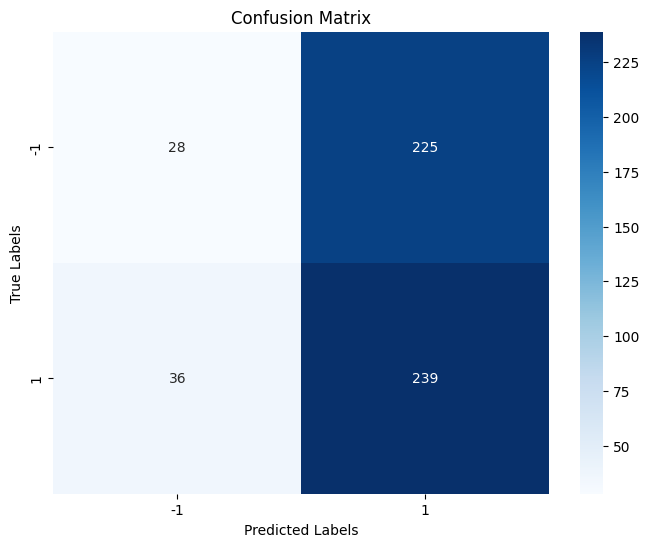

In [73]:
# Generate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Display the confusion matrix numerically
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[-1, 1], yticklabels=[-1, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# LSTM

Epoch 1/20


c:\Users\melty\anaconda3\envs\ml\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1589/1589 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.0162 - loss: 0.2534 - val_accuracy: 7.8691e-05 - val_loss: 0.1146
Epoch 2/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 5.8471e-04 - loss: 0.1177 - val_accuracy: 7.8691e-05 - val_loss: 0.1146
Epoch 3/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 6.1937e-04 - loss: 0.1058 - val_accuracy: 7.8691e-05 - val_loss: 0.1143
Epoch 4/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 5.1310e-04 - loss: 0.1314 - val_accuracy: 7.8691e-05 - val_loss: 0.1216
Epoch 5/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 7.1585e-04 - loss: 0.1195 - val_accuracy: 7.8691e-05 - val_loss: 0.1132
Epoch 6/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 9.6500e-04 - loss: 0.0682 - val_accuracy: 7.8691e-05 - val_loss: 0.1133
Epoch 7/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 4.8835e-04 - loss: 0.0831 - val_accuracy: 7.8691e-05 - val_loss: 0.1136
Epoch 8/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/

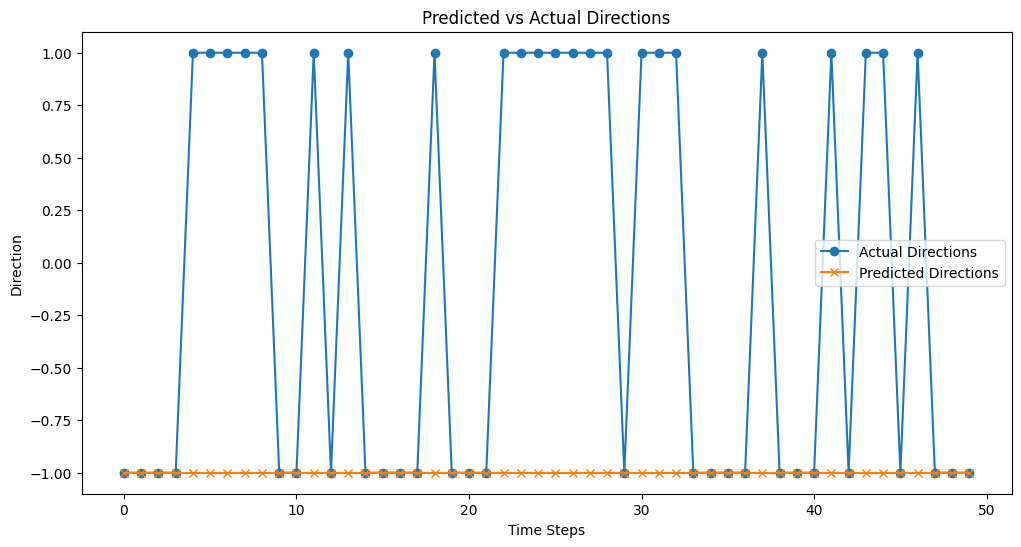

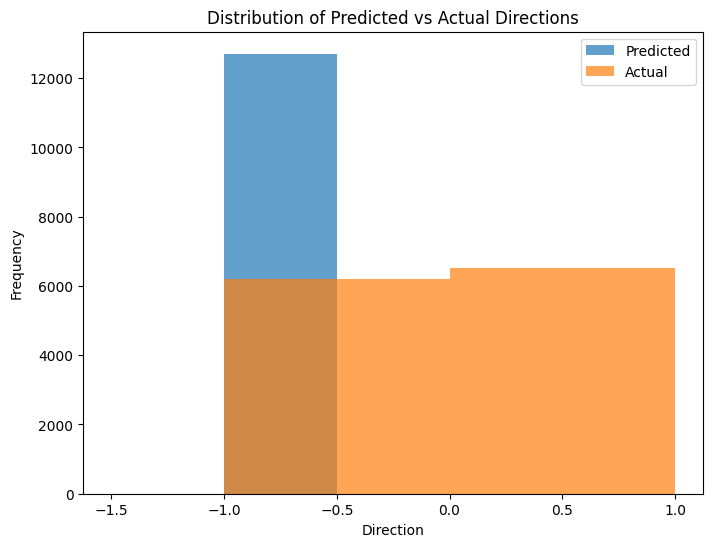

Confusion Matrix:
[[6200    0    0]
 [   1    0    0]
 [6507    0    0]]


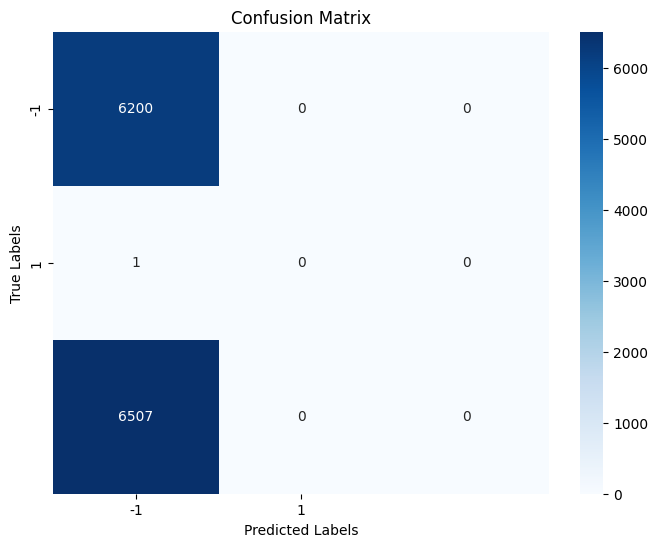

In [78]:
# Define features and target
features = ['open_diff', 'high_diff', 'low_diff', 'close_diff', 'volume', 'was_missing']
target = 'direction'
X = df_1h[features]
y = df_1h[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Function to create sequences
def create_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

# Create sequences
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y.values, time_steps=time_steps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Define the LSTM model
model = Sequential([
    LSTM(128, activation='relu', input_shape=(time_steps, X_seq.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predict the directions
y_pred_prob = model.predict(X_test)
y_pred_classes = np.where(y_pred_prob > 0.5, 1, -1)  # Convert probabilities to -1 or 1

# Visualize Predictions vs Actuals
plt.figure(figsize=(12, 6))
plt.plot(y_test[:50], label='Actual Directions', marker='o')
plt.plot(y_pred_classes[:50], label='Predicted Directions', marker='x')
plt.title('Predicted vs Actual Directions')
plt.xlabel('Time Steps')
plt.ylabel('Direction')
plt.legend()
plt.show()

# Visualize Prediction Distribution
plt.figure(figsize=(8, 6))
plt.hist(y_pred_classes, bins=2, alpha=0.7, label='Predicted')
plt.hist(y_test, bins=2, alpha=0.7, label='Actual')
plt.title('Distribution of Predicted vs Actual Directions')
plt.xlabel('Direction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Display the confusion matrix numerically
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[-1, 1], yticklabels=[-1, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Save the model
model.save('../model/LSTM/Directional_Classification_Model/lstm_direction_model_1m.h5')

# XGB